# basic indicators

## APO
The Absolute Price Oscillator (APO) is based
on the absolute differences between two moving averages of different
lengths, a ‘Fast’ and a ‘Slow’ moving average.

APO = Fast Exponential Moving Average - Slow Exponential Moving Average

### import libs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### data

In [3]:
start_date = '2021-01-01'
end_date = '2022-01-01'

goog_data = yf.download('GOOG', start=start_date, end=end_date)
# goog_data = pd.DataFrame(index=goog_data.index)
goog_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,87.876999,88.032501,85.392502,86.412003,86.412003,38038000
2021-01-05,86.250000,87.383499,85.900749,87.045998,87.045998,22906000
2021-01-06,85.131500,87.400002,84.949997,86.764503,86.764503,52042000
2021-01-07,87.002998,89.419998,86.852501,89.362503,89.362503,45300000
2021-01-08,89.399002,90.491997,88.676750,90.360497,90.360497,41012000
...,...,...,...,...,...,...
2021-12-27,147.463501,148.426498,147.250000,148.063995,148.063995,13256000
2021-12-28,148.374496,148.374496,145.935501,146.447998,146.447998,18624000
2021-12-29,146.429504,147.183746,145.504501,146.504501,146.504501,17022000


In [4]:

close = goog_data['Adj Close']

num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0
num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0

ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values

for close_price in close:
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)
  apo_values.append(ema_fast - ema_slow)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']

### plot

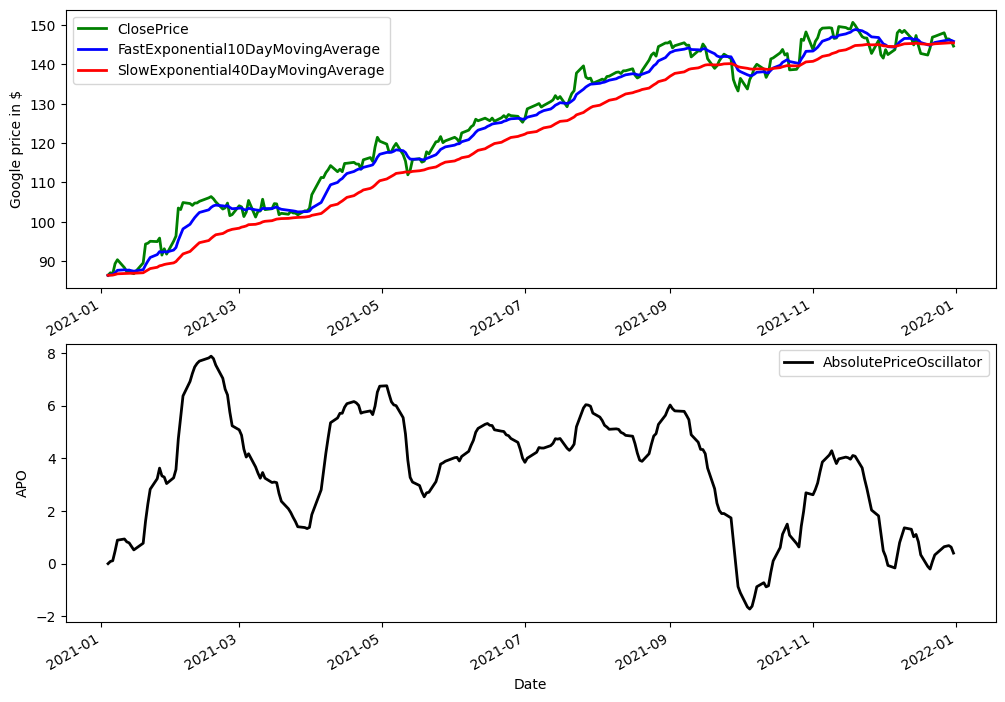

In [5]:
fig = plt.figure()
fig.set_size_inches(12, 9)
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.show()

## BBAND

The Bollinger Band (BBANDS) study created
 by John Bollinger plots upper and lower envelope bands around the
 price of the instrument. The width of the bands is based on the
 standard deviation of the closing prices from a moving average of
 price.
 Middle
 Band = n-period moving average

Upper
 Band = Middle Band + ( y * n-period standard deviation)

Lower Band = Middle Band - ( y *
 n-period standard deviation)

Where:

n = number of periods
y = factor to apply to the standard deviation value, (typical default for y = 2)
Detailed:

Calculate the moving average.
 The formula is:
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n

Pn is the price you pay for the nth interval
n is the number of periods you select
Subtract the moving average
 from each of the individual data points used in the moving average
 calculation. This gives you a list of deviations from the average.
 Square each deviation and add them all together. Divide this sum
 by the number of periods you selected.

Take the square root of d. This gives you the standard deviation.

delta = sqrt(d)

Compute the bands by using the following formulas:
Upper Band = MA + delta
Middle Band = MA
Lower Band = MA - delta

In [6]:
import statistics as stats
import math as math

time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma) # simple moving average or middle band
  variance = 0 # variance is the square of standard deviation
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation

  upper_band.append(sma + stdev_factor * stdev)
  lower_band.append(sma - stdev_factor * stdev)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=goog_data.index))

close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

### plot

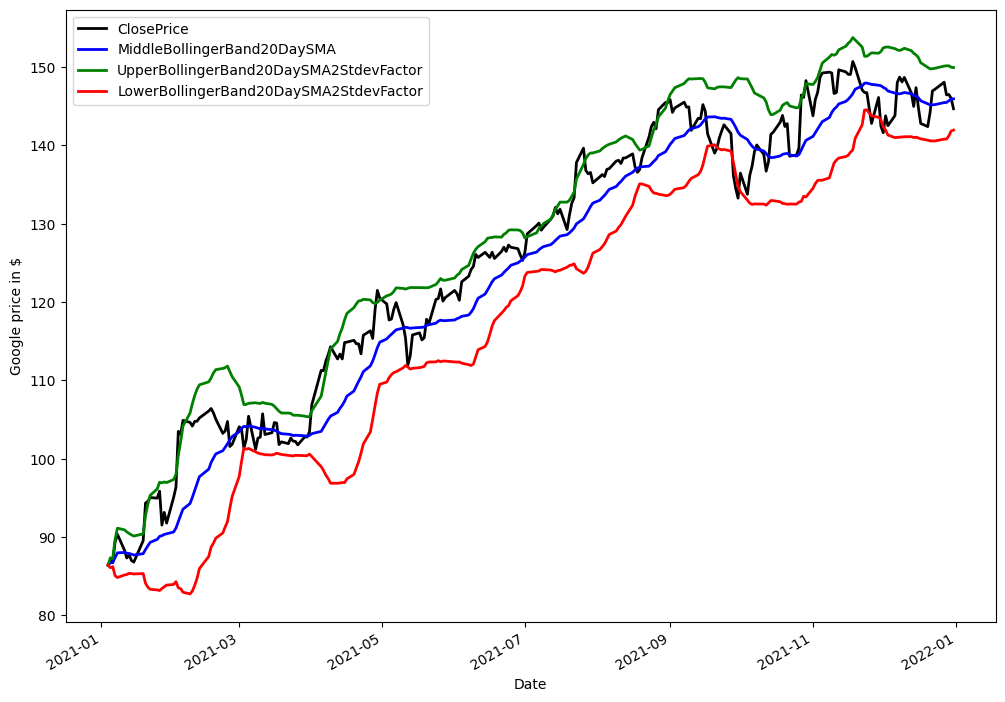

In [7]:
fig = plt.figure()
fig.set_size_inches(12, 9)
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

## EMA
The Exponential Moving Average (EMA) represents
 an average of prices, but places more weight on recent prices. The
 weighting applied to the most recent price depends on the selected
 period of the moving average. The shorter the period for the EMA,
 the more weight that will be applied to the most recent price.
 
EMA = ( P - EMAp ) * K + EMAp

Where:

P = Price for the current period
EMAp = the Exponential moving Average for the previous period
K = the smoothing constant, equal to 2 / (n + 1)
n = the number of periods in a simple moving average roughly approximated by the EMA

In [11]:

close = goog_data['Close']

num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0

ema_values = [] # to hold computed EMA values
for close_price in close:
  if (ema_p == 0): # first observation, EMA = current-price
    ema_p = close_price
  else:
    ema_p = (close_price - ema_p) * K + ema_p

  ema_values.append(ema_p)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverage=pd.Series(ema_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema = goog_data['Exponential20DayMovingAverage']

### plot

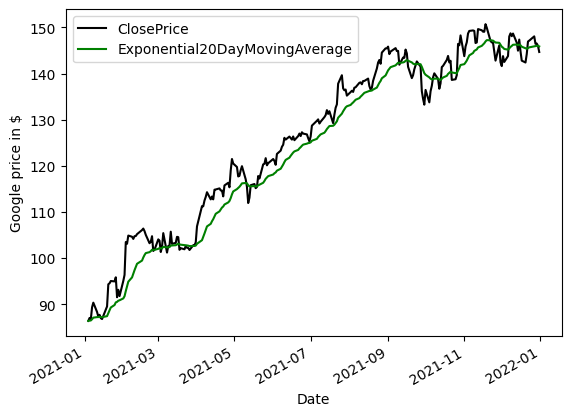

In [14]:

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', legend=True)
ema.plot(ax=ax1, color='g', legend=True)
plt.show()

## MACD
The Moving Average Convergence Divergence
 (MACD) was developed by Gerald Appel, and is based on the differences
 between two moving averages of different lengths, a Fast and a Slow moving
 average. A second line, called the Signal line is plotted as a moving
 average of the MACD. A third line, called the MACD Histogram is
 optionally plotted as a histogram of the difference between the
 MACD and the Signal Line.

 MACD = FastMA - SlowMA

Where:

FastMA is the shorter moving average and SlowMA is the longer moving average.
SignalLine = MovAvg (MACD)
MACD Histogram = MACD - SignalLine

In [16]:
close = goog_data['Close']

num_periods_fast = 10 # fast EMA time period
K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
ema_fast = 0
num_periods_slow = 40 # slow EMA time period
K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
ema_slow = 0
num_periods_macd = 20 # MACD EMA time period
K_macd = 2 / (num_periods_macd + 1) # MACD EMA smoothing factor
ema_macd = 0

ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_historgram_values = [] # MACD - MACD-EMA
for close_price in close:
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA
  if ema_macd == 0:
    ema_macd = macd
  else:
    ema_macd = (macd - ema_macd) * K_macd + ema_macd # signal is EMA of MACD values

  macd_values.append(macd)
  macd_signal_values.append(ema_macd)
  macd_historgram_values.append(macd - ema_macd)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=goog_data.index))
goog_data = goog_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistorgram']

### plot

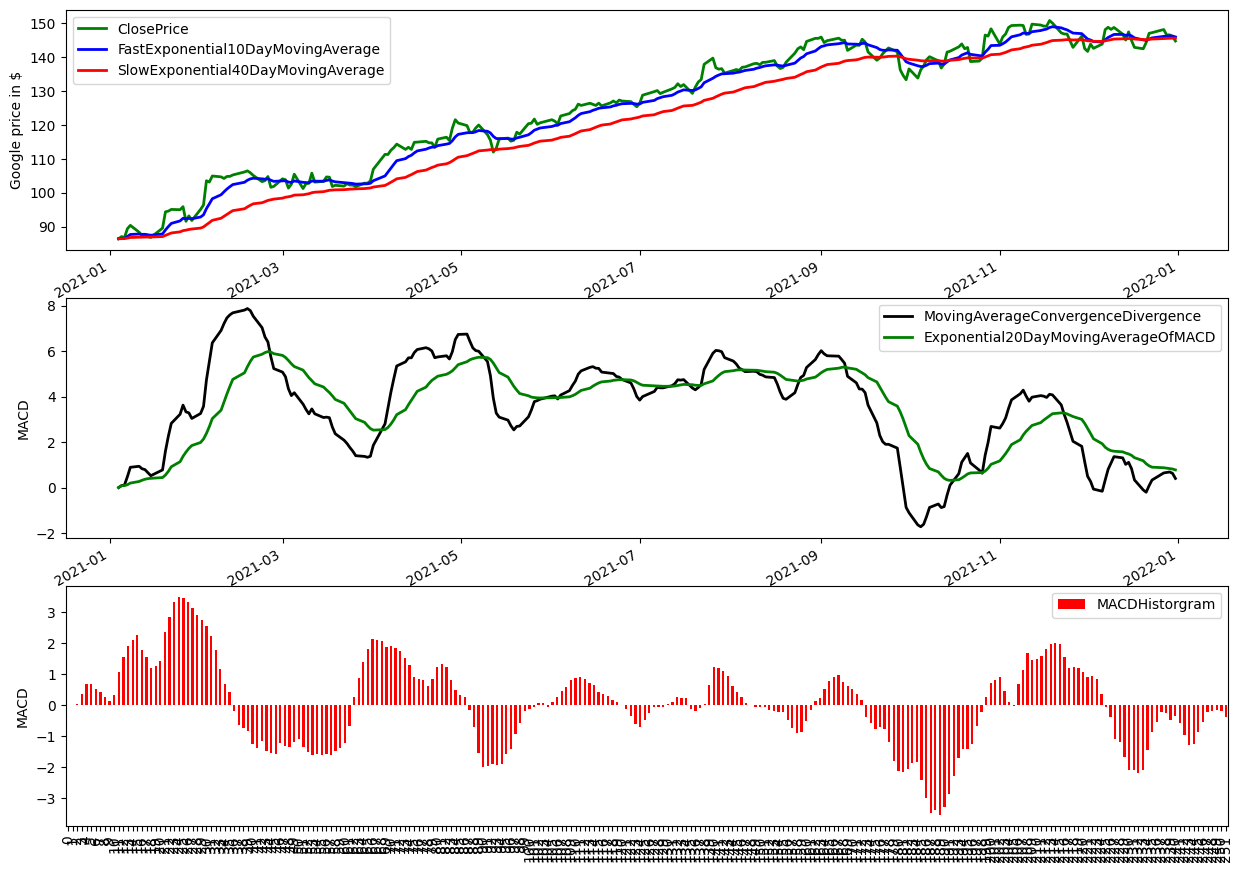

In [22]:
fig = plt.figure()
fig.set_size_inches(15, 12)
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.show()

## The Momentum (MOM) indicator compares the
 current price with the previous price from a selected number of
 periods ago. This indicator is similar to the “Rate of Change” indicator,
 but the MOM does not normalize the price, so different instruments
 can have different indicator values based on their point values.

 MOM =  Price - Price of n periods ago

In [24]:
close = goog_data['Close']

time_period = 20 # how far to look back to find reference price to compute momentum
history = [] # history of observed prices to use in momentum calculation
mom_values = [] # track momentum values for visualization purposes

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # history is at most 'time_period' number of observations
    del (history[0])

  mom = close_price - history[0]
  mom_values.append(mom)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MomentumFromPrice20DaysAgo=pd.Series(mom_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
mom = goog_data['MomentumFromPrice20DaysAgo']

### plot

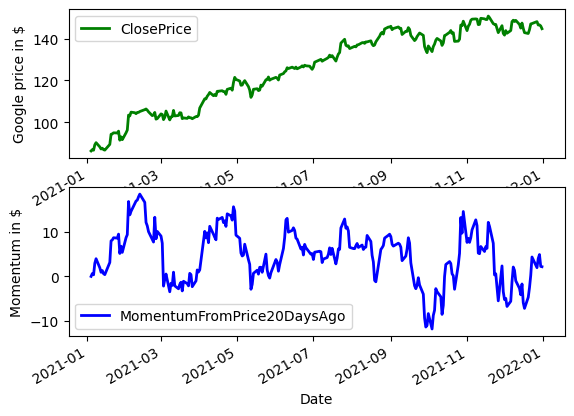

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Momentum in $')
mom.plot(ax=ax2, color='b', lw=2., legend=True)
plt.show()

## RSI
The Relative Strength Index (RSI) was published
 by J. Welles Wilder. The current price is normalized as a percentage
 between 0 and 100. The name of this oscillator is misleading because
 it does not compare the instrument relative to another instrument
 or set of instruments, but rather represents the current price relative
 to other recent pieces within the selected lookback window length.

 RSI = 100 - (100 / (1 + RS))

Where:
 RS = ratio of smoothed average of n-period gains divided by the
 absolute value of the smoothed average of n-period losses.

In [29]:
import statistics as stats

time_period = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

for close_price in close:
  if last_price == 0:
    last_price = close_price

  gain_history.append(max(0, close_price - last_price))
  loss_history.append(max(0, last_price - close_price))
  last_price = close_price

  if len(gain_history) > time_period: # maximum observations is equal to lookback period
    del (gain_history[0])
    del (loss_history[0])

  avg_gain = stats.mean(gain_history) # average gain over lookback period
  avg_loss = stats.mean(loss_history) # average loss over lookback period

  avg_gain_values.append(avg_gain)
  avg_loss_values.append(avg_loss)

  rs = 0
  if avg_loss > 0: # to avoid division by 0, which is undefined
    rs = avg_gain / avg_loss

  rsi = 100 - (100 / (1 + rs))
  rsi_values.append(rsi)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']

### plot

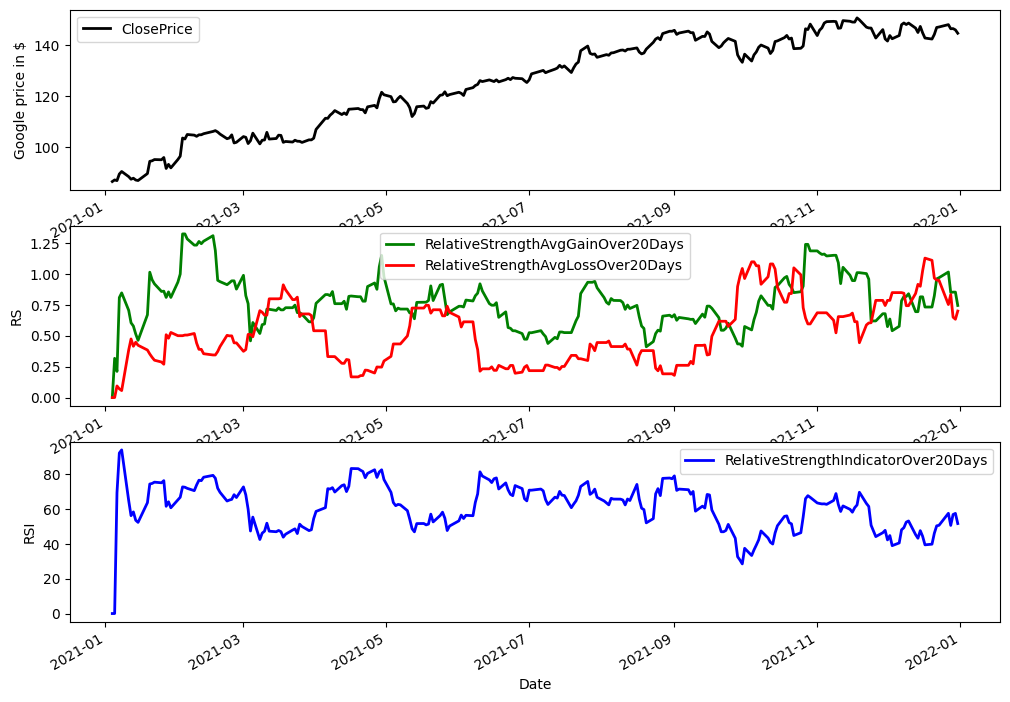

In [32]:
fig = plt.figure()
fig.set_size_inches(12, 9)
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)
plt.show()

## SMA
The Simple Moving Average (SMA) is calculated
 by adding the price of an instrument over a number of time periods
 and then dividing the sum by the number of time periods. The SMA
 is basically the average price of the given time period, with equal
 weighting given to the price of each period.

Simple Moving Average
SMA = ( Sum ( Price, n ) ) / n    

Where: n = Time Period

In [34]:
import statistics as stats

time_period = 20 # number of days over which to average
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values
for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
    del (history[0])

  sma_values.append(stats.mean(history))

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Simple20DayMovingAverage=pd.Series(sma_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
sma = goog_data['Simple20DayMovingAverage']

### plot

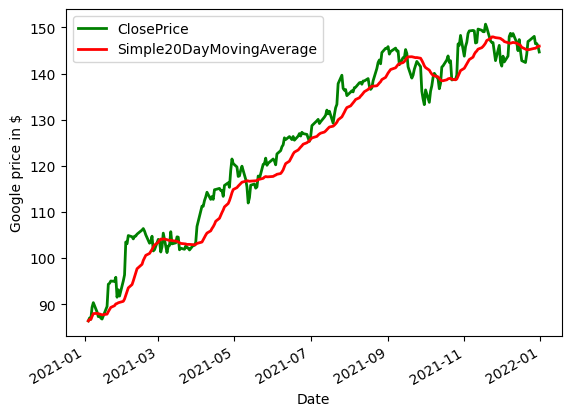

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

## stddev
Standard Deviation is a statistical calculation
 used to measure the variability. In trading this value is known
 as volatility. A low standard deviation indicates that the data
 points tend to be very close to the mean, whereas high standard
 deviation indicates that the data points are spread out over a large
 range of values.

n = number of periods

Calculate the moving average.
 The formula is:
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n

Pn is the price you pay for the nth interval
n is the number of periods you select

Take the square root of d. This gives you the standard deviation.

stddev = sqrt(d)

In [38]:
import statistics as stats
import math as math

time_period = 20 # look back period
history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes
stddev_values = [] # history of computed stdev values

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we track at most 'time_period' number of prices
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma)
  variance = 0 # variance is square of standard deviation
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(history))

  stddev_values.append(stdev)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(StandardDeviationOver20Days=pd.Series(stddev_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
stddev = goog_data['StandardDeviationOver20Days']

### plot

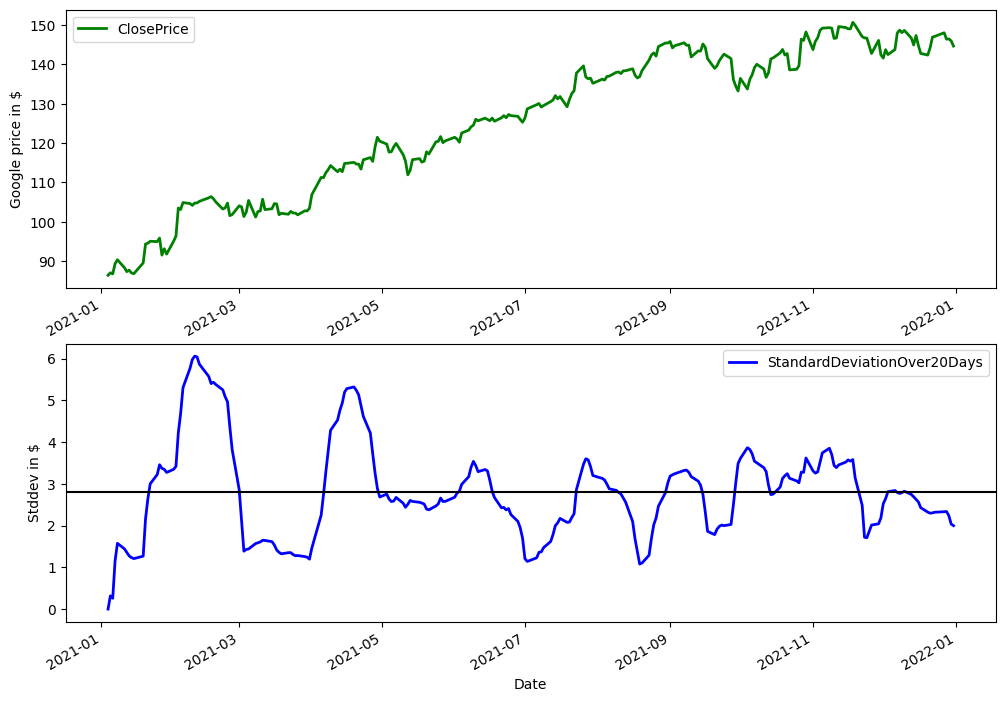

In [40]:
fig = plt.figure()
fig.set_size_inches(12, 9)
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
stddev.plot(ax=ax2, color='b', lw=2., legend=True)
ax2.axhline(y=stats.mean(stddev_values), color='k')
plt.show()